# Small Tutorial Using Fracnetics

## Summary 🔭

This notebook demonstrates how to use the **Fracnetics** library to solve the CartPole environment problem from Gymnasium (fork from OpenAI Gym).

Fractnetics is a Python library for **Genetic Network Programming (GNP)** enhanced with fractal geometry, which means it a subfield of Evolutionary Algorithms.

## Cart Pole

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

![Beschreibung](https://gymnasium.farama.org/_images/cart_pole.gif)

## Evolutionary Aglortihms 🧬

Evolutionary Algorithms are a family of optimization techniques inspired by the process of natural evolution. They work by maintaining a **population** of candidate solutions, which evolve over time through operations such as **selection, mutation, and crossover**. The idea is to iteratively improve solutions by mimicking survival of the fittest, where better solutions are more likely to be chosen and combined to form new ones. EAs are especially useful for solving complex, nonlinear, and high-dimensional problems where traditional optimization methods may fail.

## Genetic Network Programming 🦾

Genetic Network Programming is a branch of evolutionary computation that represents solutions as **networks** of nodes rather than as linear strings (like in Genetic Algorithms). Each node corresponds to a function, decision, or action, and the network’s structure allows for recurrent flows of control. This enables GNP to model adaptive, flexible, and memory-dependent behaviors. It has been applied successfully in areas such as robotics, decision-making systems, and dynamic optimization tasks.

## Next 🔥
In this tutorial we will initialize a population, train it, validate it, and finally record a run.  

Checkout Fracnetics and Gymnasium here:

- Fracnetics: https://github.com/FabianKoehnke/fracnetics
- Gymnasium: https://gymnasium.farama.org/



## Install and Load Packages

In [12]:
!pip install --upgrade fracnetics
import fracnetics as fn
import gymnasium as gym
from matplotlib import pyplot as plt
import statistics
from gymnasium.wrappers import RecordVideo


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Initializing the Population

Here we initialize the population for Fracnetics to solve the cartpole problem.

Key parameters:
- `seed`: random seed for reproducibility  
- `ni`: number of individuals  
- `jn` / `jnf`: judgment nodes and functions  
- `pn` / `pnf`: perceptron nodes and functions  
- `fractalJudgment`: enables/disables fractal-based judgment (not relevant in this tutorial)

In [31]:
seed=17
# Initialize the population
pop = fn.Population(
    seed=seed,
    ni=200,       # number of individuals
    jn=1,         # judgment nodes
    jnf=4,        # judgment node functions
    pn=2,         # perceptron nodes
    pnf=2,        # perceptron node functions
    fractalJudgment=False
)

Hints:

- We just initialized one jn and two pn because networks can grow and shrink and therefore can add judgment nodes during the evolution. See also our paper: https://link.springer.com/chapter/10.1007/978-3-031-90062-4_18
- We initialized 4 judgment nodes functions (jnf) because the observation is a ndarray with shape (4,)
- We initializes 2 processing node functions (2) because the action is a ndarray with shape (1,) which can take values {0, 1}


In [14]:
# Set input feature boundaries (based on CartPole state space)
minFeatures = [-4.8, -5, -0.418, -10]
maxFeatures = [4.8, 5, 0.418, 10]
pop.setAllNodeBoundaries(minFeatures, maxFeatures)

## Training the Population

The population is trained over 300 generations.  
Each generation involves:
1. Fitness evaluation in the Gym environment  
2. Selection (Tournament Selection)  
3. Mutation (edges)  
4. Crossover  
5. Adding/Deleting nodes  

The best fitness score from each generation is stored and plotted.  


Generation: 0 | Maximal Fitness: 151.0
Generation: 1 | Maximal Fitness: 208.0
Generation: 2 | Maximal Fitness: 266.0
Generation: 3 | Maximal Fitness: 281.0
Generation: 4 | Maximal Fitness: 261.0
Generation: 5 | Maximal Fitness: 313.0
Generation: 6 | Maximal Fitness: 295.0
Generation: 7 | Maximal Fitness: 305.0
Generation: 8 | Maximal Fitness: 305.0
Generation: 9 | Maximal Fitness: 285.0


Text(0, 0.5, 'Fitness')

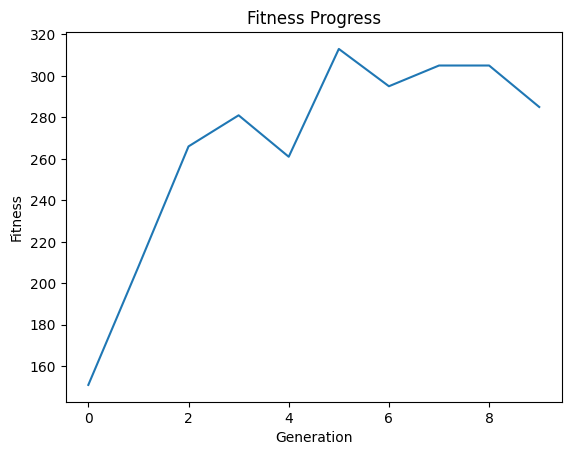

In [15]:
# Training environment
env = gym.make("CartPole-v1")
fitnessProgess = []

for g in range(10):  # 300 generations
    pop.gymnasium(
        env,
        dMax=10,
        penalty=2,
        maxSteps=500,
        maxConsecutiveP=10,
        worstFitness=0,
        seed=seed+g
    )
    # Selection
    pop.tournamentSelection(
        N=2, # tournament size
        E=1 # number of safed elite
        )
    # Mutations
    pop.callEdgeMutation(
        probInnerNodes=0.03, # probability of changing an edge of jn or pn
        probStartNode = 0.03 # probability of changing an edge of the start node
        )
    # Crossover (recombination)
    pop.crossover(probability=0.05)
    # Add/Delete nodes
    pop.callAddDelNodes(minFeatures, maxFeatures)

    maxFitness = pop.bestFit
    print(f"Generation: {g} | Maximal Fitness: {maxFitness}")
    fitnessProgess.append(maxFitness)

# Plot fitness progression
plt.plot(fitnessProgess)
plt.title("Fitness Progress")
plt.xlabel("Generation")
plt.ylabel("Fitness")

## Inspecting the Best Individual

Now we inspect the best individual:  
- Start node and its edges  
- Inner node types, functions, edges, and boundaries  

Because the Genetic Network Programming is **not** a Blackbox-Model


In [16]:
pop.individuals[-1].fitness
print(f"Start Node: {pop.individuals[-1].startNode.edges}")
for node in pop.individuals[-1].innerNodes:
  print(f"Type: {node.type} | Function: {node.f} Edges: {node.edges} | Boundaries: {node.boundaries}")

Start Node: [1]
Type: J | Function: 3 Edges: [1, 2] | Boundaries: [-10.0, 0.0, 10.0]
Type: P | Function: 0 Edges: [0] | Boundaries: []
Type: P | Function: 1 Edges: [0] | Boundaries: []
Type: P | Function: 0 Edges: [1] | Boundaries: []


## Validation of the Best Individual

The best individual is validated in a fresh environment.  
We compute the average fitness across multiple runs.  


In [17]:
env = gym.make("CartPole-v1")
validationResults = []
for v in range(10):
    pop.gymnasium(
          env,
          dMax=10,
          penalty=2,
          maxSteps=500,
          maxConsecutiveP=10,
          worstFitness=0,
          seed=seed)
    validationResults.append(pop.bestFit)
print(f"Average Fitnes of Validations: {statistics.mean(validationResults)}")

TypeError: gymnasium(): incompatible function arguments. The following argument types are supported:
    1. (self: fracnetics.fracnetics.Population, env: object, dMax: typing.SupportsInt, penalty: typing.SupportsInt, maxSteps: typing.SupportsInt, maxConsecutiveP: typing.SupportsInt, worstFitness: typing.SupportsInt, seed: typing.SupportsInt) -> None

Invoked with: <fracnetics.fracnetics.Population object at 0x111cc50f0>, <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>; kwargs: dMax=10, penalty=2, maxSteps=500, maxConsecutiveP=10, worstFitness=0

## Rendering and Recording the Best Run

Finally, we run the environment in `rgb_array` mode and use `RecordVideo`  
to save a video of the best individual playing CartPole. You can find the video in the nodebook folder "videos".


In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="videos", name_prefix="cartpole")

# Keep only the best individual
pop.individuals = [pop.individuals[-1]]

# Record a run
pop.gymnasium(
    env,
    dMax=10,
    penalty=1,
    maxSteps=500,
    maxConsecutiveP=5,
    worstFitness=0
)
env.close()

: 